# Package Import (Must Run)

In [253]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, ENGLISH_STOP_WORDS
import string
import re
from sklearn import metrics
from nltk.stem import PorterStemmer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import itertools

import matplotlib.colors as colors



# Constants and Helper Functions (Must Run)¶

In [297]:
#-----------------------------Constants-----------------------------------#
k = 1000

COMPUTER_TECHNOLOGY = 0

RECREATIONAL_ACTIVITY = 1

# index of the last computer technology data group in variable 'categories'
LAST_COMPUTER_TECHNOLOGY_INDEX = 3 


#-----------------------------Helper Functions----------------------------#

def tokenizer_stem(text):
    # Convert each punctuation character to empty character.
    punc_remove_map = text.maketrans('', '', string.punctuation)
    text_no_punc = text.translate(punc_remove_map)
    
    # remove non-ascii characters
    ascii_text_no_punc = "".join(ch for ch in text_no_punc if ord(ch) < 128) 
    
    # Convert words that share the same stem to the stem
    tokens = ascii_text_no_punc.split()
    return tokens
    #stemmer = PorterStemmer()
    #stemmed_tokens = [stemmer.stem(n) for n in tokens if not n.isdigit()]
    #return stemmed_tokens



def get_target_values(target_array):
    target_values = []
    for n in range(target_array.shape[0]):
        if target_array[n] <= LAST_COMPUTER_TECHNOLOGY_INDEX:
            target_values.append(COMPUTER_TECHNOLOGY)
        else:
            target_values.append(RECREATIONAL_ACTIVITY)
    return np.array(target_values)



def get_kmeans_results (features, true_labels, num_clusters):
    
    predicted_labels = KMeans(n_clusters=num_clusters, random_state=42).fit_predict(features)
    
    #print("contingency matrix for r =", r)
    
    contingency_matrix = confusion_matrix(true_labels, predicted_labels)
 
    scores = {}
    scores['Homogeneity'] = metrics.homogeneity_score(true_labels, predicted_labels)
    scores['Completeness'] = metrics.completeness_score(true_labels, predicted_labels)
    scores['V-measure'] = metrics.v_measure_score(true_labels, predicted_labels)
    scores['Adjusted Rand Score'] = metrics.adjusted_rand_score(true_labels, predicted_labels)
    scores['Adjusted Mutual Info Score'] = metrics.adjusted_mutual_info_score(true_labels, predicted_labels)
    
    return contingency_matrix, scores
    
def two_dimensional_clustering_plot (data, kmeans, dimension_reduction_method):
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    legend_labels = ['Computer Technology', 'Recreational Activity']
    for i in range(data.shape[1]):
        ds = data[np.where(labels==i)]
        plt.plot(ds[:, 0], ds[:, 1], 'o', label=legend_labels[i])
        lines = plt.plot(centers[i, 0], centers[i, 1], marker='x', color='k')
        plt.setp(lines, ms=15.0)
        plt.setp(lines, mew=2.0)
    plt.title('Cluster Distribution in feature space with ' + dimension_reduction_method)
    plt.legend(loc=9, bbox_to_anchor=(0.5, -0.125))
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    
    plt.show()
    
    
def plot_mat(mat, xticklabels = None, yticklabels = None, pic_fname = None, size=(-1,-1), if_show_values = True,
             colorbar = True, grid = 'k', xlabel = None, ylabel = None):
    if size == (-1, -1):
        size = (mat.shape[1] / 3, mat.shape[0] / 3)

    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(1,1,1)

    # im = ax.imshow(mat, cmap=plt.cm.Blues)
    im = ax.pcolor(mat, cmap=plt.cm.Blues, linestyle='-', linewidth=0.5, edgecolor=grid)
    
    if colorbar:
        plt.colorbar(im,fraction=0.046, pad=0.06)
    # tick_marks = np.arange(len(classes))
    # Ticks
    lda_num_topics = mat.shape[0]
    nmf_num_topics = mat.shape[1]
    yticks = np.arange(lda_num_topics)
    xticks = np.arange(nmf_num_topics)
    ax.set_xticks(xticks + 0.5)
    ax.set_yticks(yticks + 0.5)
    if not xticklabels:
        xticklabels = [str(i) for i in xticks]
    if not yticklabels:
        yticklabels = [str(i) for i in yticks]
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)

    # Minor ticks
    # ax.set_xticks(xticks, minor=True);
    # ax.set_yticks(yticks, minor=True);
    # ax.set_xticklabels([], minor=True)
    # ax.set_yticklabels([], minor=True)

    # ax.grid(which='minor', color='k', linestyle='-', linewidth=0.5)

    # tick labels on all four sides
    ax.tick_params(labelright = True, labeltop = True)

    if ylabel:
        plt.ylabel(ylabel, fontsize=15)
    if xlabel:
        plt.xlabel(xlabel, fontsize=15)

    # im = ax.imshow(mat, interpolation='nearest', cmap=plt.cm.Blues)
    ax.invert_yaxis()

    # thresh = mat.max() / 2

    def show_values(pc, fmt="%.3f", **kw):
        pc.update_scalarmappable()
        ax = pc.axes
        for p, color, value in itertools.zip_longest(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
            x, y = p.vertices[:-2, :].mean(0)
            if np.all(color[:3] > 0.5):
                color = (0.0, 0.0, 0.0)
            else:
                color = (1.0, 1.0, 1.0)
            ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw, fontsize=4)

    if if_show_values:
        show_values(im)
    # for i, j in itertools.product(range(mat.shape[0]), range(mat.shape[1])):
    #     ax.text(j, i, "{:.2f}".format(mat[i, j]), fontsize = 4,
    #              horizontalalignment="center",
    #              color="white" if mat[i, j] > thresh else "black")

    if pic_fname:
        plt.savefig(pic_fname, dpi=300, transparent=True)


# Classification Preparation (Must Run)

In [300]:
# Extract datasets
categories = ['comp.graphics',
              'comp.os.ms-windows.misc',
              'comp.sys.ibm.pc.hardware',
              'comp.sys.mac.hardware',
              'rec.autos',
              'rec.motorcycles',
              'rec.sport.baseball',
              'rec.sport.hockey']

dataset = fetch_20newsgroups(subset='all', categories=categories, shuffle=True, random_state=42)

# Set labels for binary classifiers
targets = get_target_values(dataset.target)


# Initialize term count vectorizers
count_vectorizer = CountVectorizer(
    analyzer = 'word',
    stop_words = ENGLISH_STOP_WORDS,
    min_df = 3
)

word_count = count_vectorizer.fit_transform(dataset.data)

# TFIDF transformer
tfidf_transformer = TfidfTransformer()
# Compute tfidf Matrices
tfidf = tfidf_transformer.fit_transform(word_count)

# Problem 1

In [77]:
print("Dimensions of TF-IDF matrix: "+ str(tfidf.shape))

Dimensions of TF-IDF matrix: (7882, 27768)


# Problem 2

In [80]:
#(a)
kmeans = KMeans(n_clusters=2, random_state=42).fit(tfidf)
confusionmatrix = confusion_matrix(targets, kmeans.labels_, labels = [COMPUTER_TECHNOLOGY, RECREATIONAL_ACTIVITY])
print("contingency matrix:")
print(confusionmatrix)


contingency matrix:
[[   4 3899]
 [1717 2262]]


In [82]:
#(b)
print("Homogeneity: %f" % metrics.homogeneity_score(targets, kmeans.labels_))
print("Completeness: %f" % metrics.completeness_score(targets, kmeans.labels_))
print("V-measure: %f" % metrics.v_measure_score(targets, kmeans.labels_))
print("Adjusted Rand Score: %f" % metrics.adjusted_rand_score(targets, kmeans.labels_))
print("Adjusted Mutual Info Score: %f" % metrics.adjusted_mutual_info_score(targets, kmeans.labels_))

Homogeneity: 0.253413
Completeness: 0.334677
V-measure: 0.288430
Adjusted Rand Score: 0.180546
Adjusted Mutual Info Score: 0.253345


# Problem 3

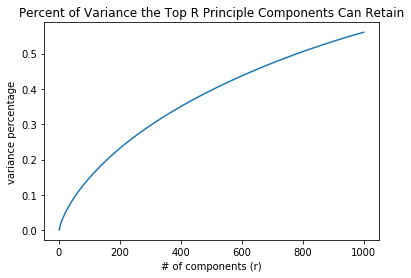

In [84]:
# (a), plot of the percent of variance the toprprinciple components canretain v.s r
lsa_model = TruncatedSVD(n_components=1000, random_state=42)
tfidf_lsa = lsa_model.fit(tfidf)
variance_ratio = tfidf_lsa.explained_variance_ratio_

#plotting variance curve
plt.plot(range(1, 1001), np.cumsum(variance_ratio))
plt.xlabel('# of components (r)')
plt.ylabel('variance percentage')
plt.title('Percent of Variance the Top R Principle Components Can Retain')
plt.show()



contingency matrix when r = 1
[[2195 1708]
 [2318 1661]]
contingency matrix when r = 2
[[3691  212]
 [ 436 3543]]
contingency matrix when r = 3
[[3874   29]
 [1492 2487]]
contingency matrix when r = 5
[[   5 3898]
 [1543 2436]]
contingency matrix when r = 10
[[   3 3900]
 [1607 2372]]
contingency matrix when r = 20
[[3900    3]
 [2364 1615]]
contingency matrix when r = 50
[[3899    4]
 [2325 1654]]
contingency matrix when r = 100
[[   3 3900]
 [1670 2309]]
contingency matrix when r = 300
[[   3 3900]
 [1643 2336]]


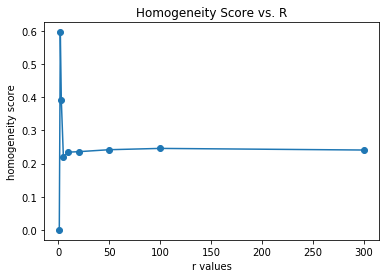

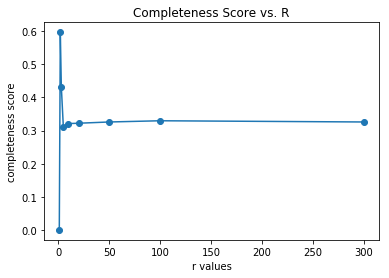

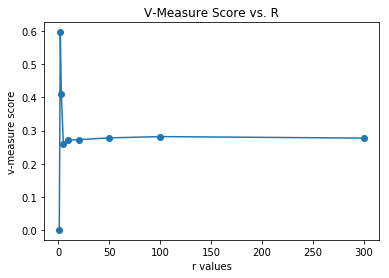

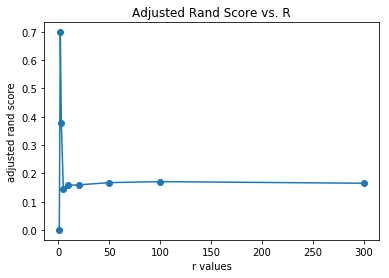

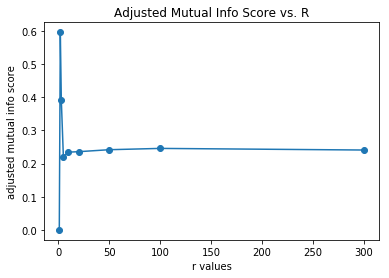

In [93]:

# (b) find best r using SVD

r_list = [1, 2, 3, 5, 10, 20, 50, 100, 300]
homogeneity = []
completeness = []
v_measure = []
adjusted_rand = []
adjusted_mutual_info = []
for r in r_list:
    features = TruncatedSVD(n_components=r, random_state=42).fit_transform(tfidf)
    contingency_matrix, scores = get_kmeans_results (features, targets, 2)
    print("contingency matrix when r =", r)
    print(contingency_matrix)
    homogeneity.append(scores[0])
    completeness.append(scores[1])
    v_measure.append(scores[2])
    adjusted_rand.append(scores[3])
    adjusted_mutual_info.append(scores[4])
    
plt.plot(r_list, homogeneity, '-o')
plt.xlabel('r values')
plt.ylabel('homogeneity score')
plt.title('Homogeneity Score vs. R')
plt.show()

plt.plot(r_list, completeness, '-o')
plt.xlabel('r values')
plt.ylabel('completeness score')
plt.title('Completeness Score vs. R')
plt.show()

plt.plot(r_list, v_measure, '-o')
plt.xlabel('r values')
plt.ylabel('v-measure score')
plt.title('V-Measure Score vs. R')
plt.show()

plt.plot(r_list, adjusted_rand, '-o')
plt.xlabel('r values')
plt.ylabel('adjusted rand score')
plt.title('Adjusted Rand Score vs. R')
plt.show()

plt.plot(r_list, adjusted_mutual_info, '-o')
plt.xlabel('r values')
plt.ylabel('adjusted mutual info score')
plt.title('Adjusted Mutual Info Score vs. R')
plt.show()


contingency matrix when r = 1
[[2195 1708]
 [2318 1661]]
contingency matrix when r = 2
[[3594  309]
 [ 158 3821]]
contingency matrix when r = 3
[[3899    4]
 [2396 1583]]
contingency matrix when r = 5
[[3898    5]
 [2677 1302]]
contingency matrix when r = 10
[[3899    4]
 [2627 1352]]
contingency matrix when r = 20
[[3899    4]
 [2511 1468]]
contingency matrix when r = 50
[[3895    8]
 [3922   57]]
contingency matrix when r = 100
[[   3 3900]
 [ 413 3566]]
contingency matrix when r = 300
[[ 113 3790]
 [   0 3979]]


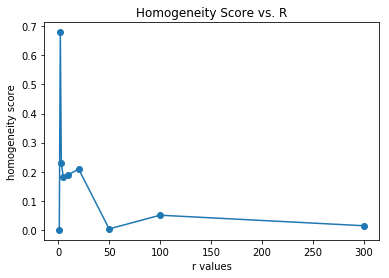

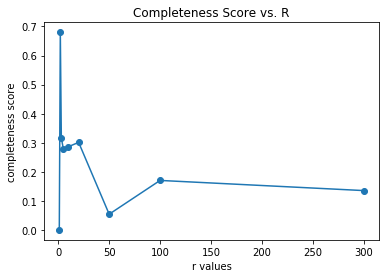

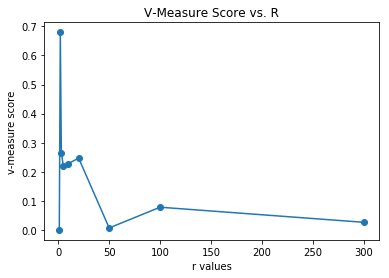

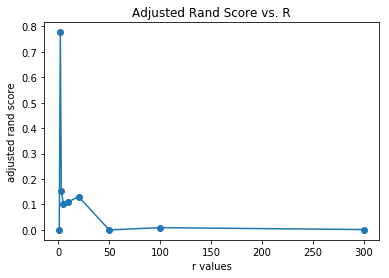

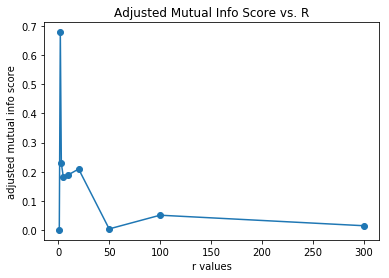

In [249]:
# (b) find best r using NMF
r_list = [1,2,3,5,10,20,50,100,300]
homogeneity = []
completeness = []
v_measure = []
adjusted_rand = []
adjusted_mutual_info = []
for r in r_list:
    features = NMF(n_components=r, random_state=42).fit_transform(tfidf)
    contingency_matrix, scores = get_kmeans_results (features, targets, 2)
    print("contingency matrix when r =", r)
    print(contingency_matrix)
    homogeneity.append(scores['Homogeneity'])
    completeness.append(scores['Completeness'])
    v_measure.append(scores['V-measure'])
    adjusted_rand.append(scores['Adjusted Rand Score'])
    adjusted_mutual_info.append(scores['Adjusted Mutual Info Score'])
    
plt.plot(r_list, homogeneity, '-o')
plt.xlabel('r values')
plt.ylabel('homogeneity score')
plt.title('Homogeneity Score vs. R')
plt.show()

plt.plot(r_list, completeness, '-o')
plt.xlabel('r values')
plt.ylabel('completeness score')
plt.title('Completeness Score vs. R')
plt.show()

plt.plot(r_list, v_measure, '-o')
plt.xlabel('r values')
plt.ylabel('v-measure score')
plt.title('V-Measure Score vs. R')
plt.show()

plt.plot(r_list, adjusted_rand, '-o')
plt.xlabel('r values')
plt.ylabel('adjusted rand score')
plt.title('Adjusted Rand Score vs. R')
plt.show()

plt.plot(r_list, adjusted_mutual_info, '-o')
plt.xlabel('r values')
plt.ylabel('adjusted mutual info score')
plt.title('Adjusted Mutual Info Score vs. R')
plt.show()

# Problem 4

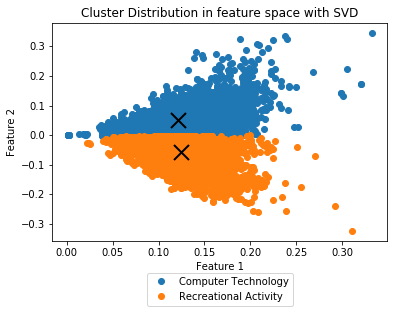

[[3691  212]
 [ 436 3543]]


In [301]:
#(a) using best result in SVD which is r = 2 to visualize the clustering results 
best_lsa_data = TruncatedSVD(n_components=2, random_state=42).fit_transform(tfidf)
kmeans_best_lsa = KMeans(n_clusters=2, random_state=42).fit(best_lsa_data)
two_dimensional_clustering_plot (best_lsa_data, kmeans_best_lsa, 'SVD where r = 2')
confusionmatrix = confusion_matrix(targets, kmeans_best_lsa.labels_)
print(confusionmatrix)

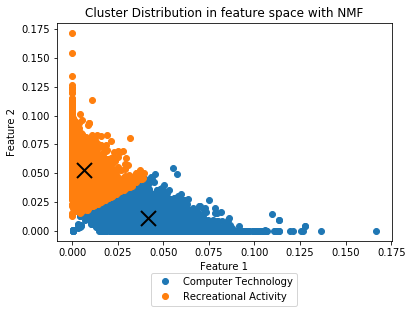

[[3594  309]
 [ 158 3821]]


In [302]:
#(a) using best result in NMF which is r = 2 to visualize the clustering results
nmf = NMF(n_components=2, random_state = 42)
best_nmf_data = nmf.fit_transform(tfidf)
kmeans_best_nmf = KMeans(n_clusters=2, random_state=42).fit(best_nmf_data)
two_dimensional_clustering_plot (best_nmf_data, kmeans_best_nmf, 'NMF where r = 2')
confusionmatrix = confusion_matrix(targets, kmeans_best_nmf.labels_)
print(confusionmatrix)

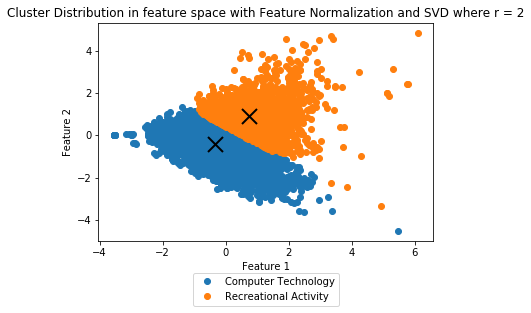

[[1705 2198]
 [3733  246]]


In [304]:
# (b) normalized features, SVD where r = 2
lsa = TruncatedSVD(n_components=2, random_state=42)
best_lsa_data = lsa.fit_transform(tfidf)

best_lsa_data = StandardScaler().fit_transform(best_lsa_data)

kmeans_best_lsa = KMeans(n_clusters=2, random_state=42).fit(best_lsa_data)
two_dimensional_clustering_plot (best_lsa_data, kmeans_best_lsa, 'Feature Normalization and SVD where r = 2')
confusionmatrix = confusion_matrix(targets, kmeans_best_lsa.labels_)
print(confusionmatrix)

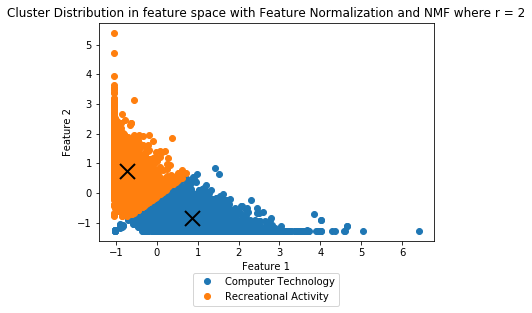

[[3534  369]
 [ 106 3873]]


In [305]:
# (b) normalized features, NMF where r = 2
nmf = NMF(n_components=2, random_state = 42)
best_nmf_data = nmf.fit_transform(tfidf)
best_nmf_data = StandardScaler().fit_transform(best_nmf_data)
kmeans_best_nmf = KMeans(n_clusters=2, random_state=42).fit(best_nmf_data)
two_dimensional_clustering_plot(best_nmf_data, kmeans_best_nmf, 'Feature Normalization and NMF where r = 2')
confusionmatrix = confusion_matrix(targets, kmeans_best_nmf.labels_)
print(confusionmatrix)

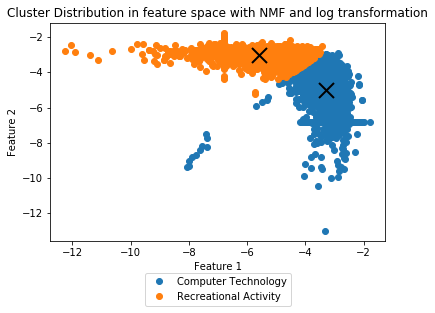

[[3701  202]
 [ 189 3790]]


In [306]:
# (b) log transformation, NMF where r = 2
nmf = NMF(n_components=2, random_state = 42)
best_nmf_data = nmf.fit_transform(tfidf)

for x in np.nditer(best_nmf_data, op_flags=['readwrite']):
    if x == 0:
        x[...] = x + 0.00111

best_nmf_data = np.log(best_nmf_data)
kmeans_best_nmf = KMeans(n_clusters=2, random_state=42).fit(best_nmf_data)
two_dimensional_clustering_plot (best_nmf_data, kmeans_best_nmf, 'NMF and log transformation')
confusionmatrix = confusion_matrix(targets, kmeans_best_nmf.labels_)
print(confusionmatrix)

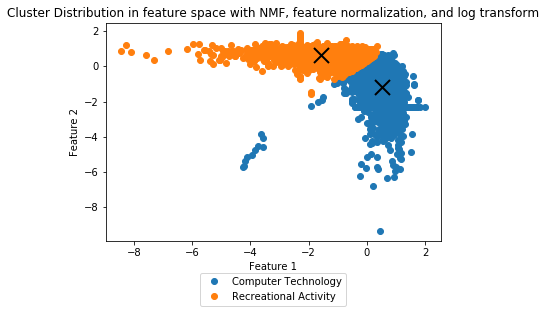

[[3671  232]
 [ 170 3809]]


In [307]:
# (b) normalized features -> log transformation, NMF where r = 2
nmf = NMF(n_components=2, random_state = 42)
best_nmf_data = nmf.fit_transform(tfidf)
best_nmf_data = StandardScaler(with_mean=False).fit_transform(best_nmf_data)


for x in np.nditer(best_nmf_data, op_flags=['readwrite']):
    if x == 0:
        x[...] = x + 0.1

best_nmf_data = np.log(best_nmf_data)
kmeans_best_nmf = KMeans(n_clusters=2, random_state=42).fit(best_nmf_data)
two_dimensional_clustering_plot (best_nmf_data, kmeans_best_nmf, 'NMF, feature normalization, and log transform')
confusionmatrix = confusion_matrix(targets, kmeans_best_nmf.labels_)
print(confusionmatrix)

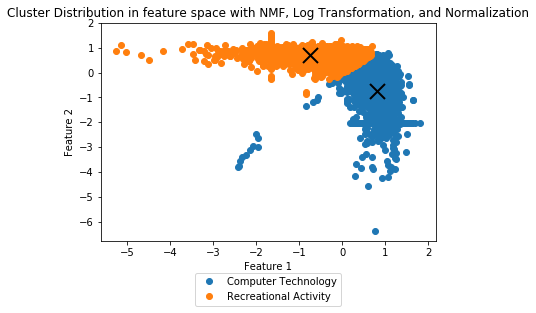

[[3656  247]
 [ 153 3826]]


In [309]:
# (b)  log transformation -> normalized features, NMF where r = 2
nmf = NMF(n_components=2, random_state = 42)
best_nmf_data = nmf.fit_transform(tfidf)
for x in np.nditer(best_nmf_data, op_flags=['readwrite']):
    if x == 0:
        x[...] = x + 0.001

best_nmf_data = np.log(best_nmf_data )
best_nmf_data = StandardScaler().fit_transform(best_nmf_data)
kmeans_best_nmf = KMeans(n_clusters=2, random_state=42).fit(best_nmf_data)
two_dimensional_clustering_plot (best_nmf_data, kmeans_best_nmf, 'NMF, Log Transformation, and Normalization')
confusionmatrix = confusion_matrix(targets, kmeans_best_nmf.labels_)
print(confusionmatrix)

# Problem 5

In [283]:
# Extract datasets

dataset = fetch_20newsgroups(subset='all', shuffle=True, random_state=42)

# Set labels for classifiers
targets = dataset.target


# Initialize term count vectorizers
count_vectorizer = CountVectorizer(
    analyzer = 'word',
    stop_words = ENGLISH_STOP_WORDS,
    min_df = 3
)

word_count = count_vectorizer.fit_transform(dataset.data)

# TFIDF transformer
tfidf_transformer = TfidfTransformer()
# Compute tfidf Matrices
tfidf = tfidf_transformer.fit_transform(word_count)

In [284]:
print("Dimensions of TF-IDF matrix: "+ str(tfidf.shape))


Dimensions of TF-IDF matrix: (18846, 52295)


contingency matrix:
[[  3   1 154  67   1 151   0  41 156   0  34   0  89   4  98   0   0   0
    0   0]
 [ 42  17   1  77   0 264   2   0  16   0   7  97   4   1 297   8   0 140
    0   0]
 [ 45   3   0  34   0 139   2   0   9  10  16  82   2   0 133   3   0 507
    0   0]
 [ 41   6   0  26   0 127   3   0   5 179  30 321   0   0 169  16   2  57
    0   0]
 [ 41   8   0  23   0 202  13   0  11  66  26 469   1   0  90   6   0   7
    0   0]
 [ 20  26   0  93   4 171   2   0   1   0   5   9   0   0 416   5   0 236
    0   0]
 [ 21   3   0   5   0 142  31   0   4  39  14  54   0   6 138 502   6  10
    0   0]
 [ 41   8   0  23   0 259  31   0  41   0  23   0  19   4 524  14   0   3
    0   0]
 [117  15   0 100   0 197   6   0   7   0   9   0   9   0 512  24   0   0
    0   0]
 [ 30   3   0   2   0 384   7   0  19   0   3   0   3   4 180   3 356   0
    0   0]
 [ 91   3   0   2   0 111   6   0   2   0   6   0   1   0  69  28 680   0
    0   0]
 [ 12  21   0  51 528 100   9   0   3   0   0

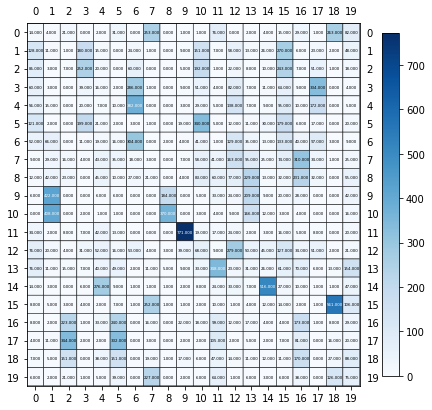

In [285]:
confusionmatrix, scores = get_kmeans_results (tfidf, targets, 20)
print("contingency matrix:")
print(confusionmatrix)
plot_mat(contingency_matrix)

print("Homogeneity: %f" % scores['Homogeneity'])
print("Completeness: %f" % scores['Completeness'])
print("V-measure: %f" % scores['V-measure'])
print("Adjusted Rand Score: %f" % scores['Adjusted Rand Score'])
print("Adjusted Mutual Info Score: %f" % scores['Adjusted Mutual Info Score'])



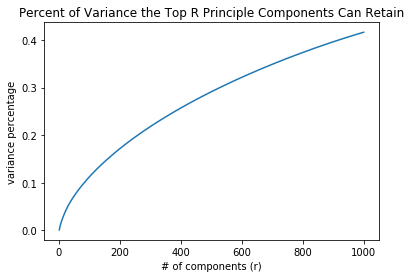

In [228]:
# plot of the percent of variance the toprprinciple components canretain v.s r
lsa_model = TruncatedSVD(n_components=1000, random_state=42)
tfidf_lsa = lsa_model.fit(tfidf)
variance_ratio = tfidf_lsa.explained_variance_ratio_

#plotting variance curve
plt.plot(range(1, 1001), np.cumsum(variance_ratio))
plt.xlabel('# of components (r)')
plt.ylabel('variance percentage')
plt.title('Percent of Variance the Top R Principle Components Can Retain')
plt.show()

contingency matrix when r = 1
[[ 31  67  66  51   5   1  47  81  12  45   0  14  78  66   0  82  24  20
   89  20]
 [120  28  68   8   3  46 107  49   2 119  24  70  24  95   2  43   5   3
   56 101]
 [ 75  37 110  28   0  18  94  73   3  94  23  49  37  99   0  61  16   4
  115  49]
 [ 95  62  94  31   0  28  94  84   1  77   3  51  31 106   0  51  13   2
   87  72]
 [ 92  48 101  24   3  34 101  72   2  99   2  43  37  86   0  57   7   1
   82  72]
 [116  20  80   5   7  82  83  51   1 105  18 106  16  79   0  30   5   1
   53 130]
 [109  27  82  10   1  59 108  68   0 127   6  92   9  79   0  37   3   0
   57 101]
 [ 73  54  94  26   1  26  94  75   1  86   2  60  31 107   0  48  14   9
  106  83]
 [100  30 120  10   0  17 104  70   0 118   0  43  38 130   0  44   6   2
   85  79]
 [ 86  48  93  18   1  27 106 104   1  88   5  42  38  77   0  77  21   8
   94  60]
 [ 89  45 106  11   1  45  96  87   1  91   8  56  28  94   0  53  11   5
   89  83]
 [ 39 104  77  56   3   5  61 112  

contingency matrix when r = 20
[[  1   1   0  62   0 150  38   0   0 149 138 170   1   0  22  66   0   0
    0   1]
 [  1   0   0  94   0   7   0   0   0   1   0 472  17   2   7 143   0   0
  227   2]
 [  0   0  11  33   0   5   0   0   0   0   0 197   3   2  14  78   0   0
  631  11]
 [  0   0 197  32   0   1   0   0   4   0   0 320   8   3  29 218   0   0
  166   4]
 [  0   0  78  26   0   8   1   0   1   0   0 593  10  14  24 155   0   0
   52   1]
 [  0   4   0  97   0   1   0   0   0   0   0 333  25   2   4 210   0   0
  311   1]
 [  3   0  54   5   0   4   0   0  12   0   0 591   4  33  13 210   0   0
   40   6]
 [  2   0   0  27   0 118   0   0   0   0   0 323  12  31  20 455   0   0
    2   0]
 [  0   0   0 103   0  40   0   0   2   0   0 238  20   7   9 576   0   0
    0   1]
 [  4   0   0   2   0  26   0   0 419   0   0 379   3   7   1 152   0   0
    0   1]
 [  0   0   0   3   0   2   0   0 779   0   0 150   3   6   5  51   0   0
    0   0]
 [ 16 494   0  49   0  77   0   0 

contingency matrix when r = 1000
[[  0 193   5   0   0   0   1  14 136   0   0  28   1 126   0  71   1   1
    0 222]
 [  3   1   1  14   0 180  17   0   0   1   0   7   0 156   1  78   0  16
    2 496]
 [  0   0   0   5   0 558   3   0   0   5   0  15   0  89   3  30   0  20
   11 246]
 [  0   0   0  14   0 457  12   0   0   5   0  31   0 151   1  29   3   8
    5 266]
 [  0   0   0  59   0 178  12   0   0   0   0  24   0 119   4  20   0  12
    1 534]
 [  0   0   0  16   0 162  29   0   0   0   0   4   4 260   1  93   0   2
    2 415]
 [  0   0   0   2   0 135   4   0   0   2   0  14   0 183   8   5  12   2
    7 601]
 [  0   0   6  19   0   2   9   0   0   1   0  22   0 510   2  22   0   2
    0 395]
 [  0   0   0   2   0   0  17   0   0   0   0   9   0 567   1 108   0   2
    1 289]
 [  0   0   4   0   0   0   5   0   0   2   0   3   0 148   3   2 479   1
    1 346]
 [  0   0   0  27   0   0   6   0   0   0   0   6   0  43   8   2 763   0
    0 144]
 [  0   0  33   0   1  10   7   

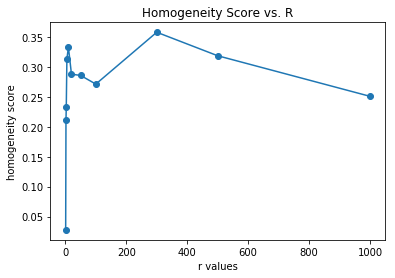

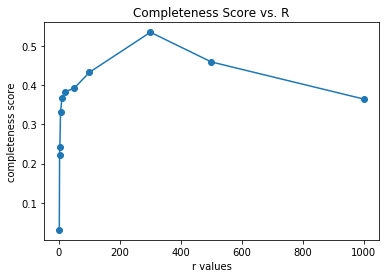

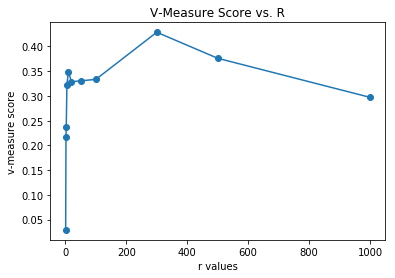

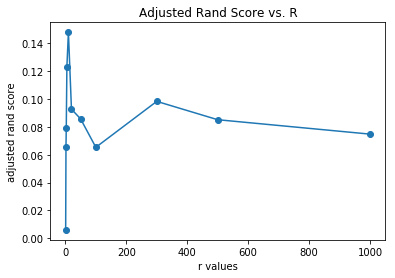

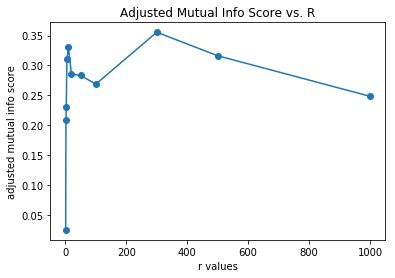

In [231]:
# (b) find best r using SVD

r_list = [1, 2, 3, 5, 10, 20, 50, 100, 300, 500, 1000]
homogeneity = []
completeness = []
v_measure = []
adjusted_rand = []
adjusted_mutual_info = []
for r in r_list:
    features = TruncatedSVD(n_components=r, random_state=42).fit_transform(tfidf)
    contingency_matrix, scores = get_kmeans_results (features, targets, 20)
    print("contingency matrix when r =", r)
    print(contingency_matrix)
    homogeneity.append(scores['Homogeneity'])
    completeness.append(scores['Completeness'])
    v_measure.append(scores['V-measure'])
    adjusted_rand.append(scores['Adjusted Rand Score'])
    adjusted_mutual_info.append(scores['Adjusted Mutual Info Score'])
    
plt.plot(r_list, homogeneity, '-o')
plt.xlabel('r values')
plt.ylabel('homogeneity score')
plt.title('Homogeneity Score vs. R')
plt.show()

plt.plot(r_list, completeness, '-o')
plt.xlabel('r values')
plt.ylabel('completeness score')
plt.title('Completeness Score vs. R')
plt.show()

plt.plot(r_list, v_measure, '-o')
plt.xlabel('r values')
plt.ylabel('v-measure score')
plt.title('V-Measure Score vs. R')
plt.show()

plt.plot(r_list, adjusted_rand, '-o')
plt.xlabel('r values')
plt.ylabel('adjusted rand score')
plt.title('Adjusted Rand Score vs. R')
plt.show()

plt.plot(r_list, adjusted_mutual_info, '-o')
plt.xlabel('r values')
plt.ylabel('adjusted mutual info score')
plt.title('Adjusted Mutual Info Score vs. R')
plt.show()

contingency matrix when r = 1
[[ 31  67  66  51   5   1  47  81  12  45   0  14  78  66   0  82  24  20
   89  20]
 [120  28  68   8   3  46 107  49   2 119  24  70  24  95   2  43   5   3
   56 101]
 [ 75  37 110  28   0  18  94  73   3  94  23  49  37  99   0  61  16   4
  115  49]
 [ 95  62  95  31   0  28  94  84   1  77   3  51  31 105   0  51  13   2
   87  72]
 [ 92  48 100  24   3  34 101  72   2  99   2  43  37  86   0  57   7   1
   83  72]
 [116  20  80   5   7  82  82  51   1 105  18 106  16  80   0  30   5   1
   53 130]
 [109  27  82  10   1  59 108  68   0 127   6  92   9  79   0  37   3   0
   57 101]
 [ 73  54  94  26   1  26  94  74   1  86   2  60  31 107   0  49  14   9
  106  83]
 [100  30 120  10   0  17 103  70   0 118   0  43  38 131   0  44   6   2
   85  79]
 [ 86  48  93  18   1  27 106 104   1  88   5  42  38  77   0  77  21   8
   94  60]
 [ 89  45 106  11   1  45  96  87   1  91   8  56  28  94   0  53  11   5
   89  83]
 [ 39 104  78  56   3   5  61 113  

contingency matrix when r = 20
[[  0   1  78 290  38  44   0   2   0 144   0  69   0   0   1   0   1   3
    0 128]
 [  0   0 120 401   0   1   2   1 340   1   0  82   0   0   2   0  16   7
    0   0]
 [  0   0  67 177   0  11   2   0 660   0   0  35   0   0  12   0   2   9
   10   0]
 [  4   0 180 302   0  16   3   0 213   0   0  29   0   0   4   0  10  21
  200   0]
 [  1   0 118 576   0  25  14   0  98   0   0  24   0   0   1   0  10  14
   82   0]
 [  0   5 154 299   0   2   2   0 407   0   0  87   0   0   2   0  27   3
    0   0]
 [ 14   0 159 615   0   3  33   5  58   1   0   5   0   0   7   0   4  12
   59   0]
 [  0   0 393 490   0  25  32   3   3   0   0  27   0   0   1   0  11   5
    0   0]
 [  2   0 510 336   0   8   6   0   0   0   0 108   0   0   1   0  17   8
    0   0]
 [382   0 147 440   0   6   7   4   0   0   0   2   0   0   1   0   4   1
    0   0]
 [778   0  35 167   0   4   6   0   0   0   0   2   0   0   0   0   3   4
    0   0]
 [  0 486 168 205   0   0   8  16 

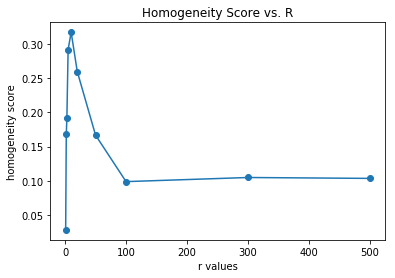

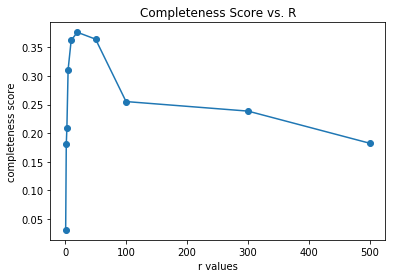

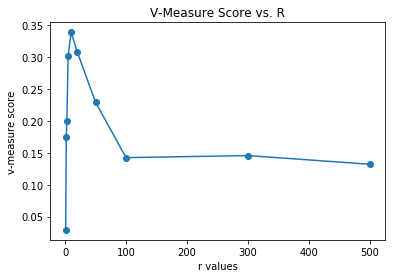

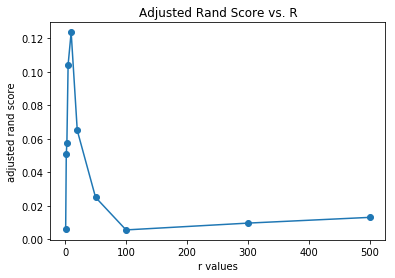

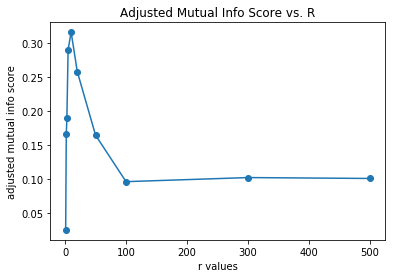

In [236]:
# (b) find best r using NMF
r_list = [1,2,3,5,10,20,50,100,300, 500]
homogeneity = []
completeness = []
v_measure = []
adjusted_rand = []
adjusted_mutual_info = []
for r in r_list:
    features = NMF(n_components=r, random_state=42).fit_transform(tfidf)
    contingency_matrix, scores = get_kmeans_results (features, targets, 20)
    print("contingency matrix when r =", r)
    print(contingency_matrix)
    homogeneity.append(scores['Homogeneity'])
    completeness.append(scores['Completeness'])
    v_measure.append(scores['V-measure'])
    adjusted_rand.append(scores['Adjusted Rand Score'])
    adjusted_mutual_info.append(scores['Adjusted Mutual Info Score'])
    
plt.plot(r_list, homogeneity, '-o')
plt.xlabel('r values')
plt.ylabel('homogeneity score')
plt.title('Homogeneity Score vs. R')
plt.show()

plt.plot(r_list, completeness, '-o')
plt.xlabel('r values')
plt.ylabel('completeness score')
plt.title('Completeness Score vs. R')
plt.show()

plt.plot(r_list, v_measure, '-o')
plt.xlabel('r values')
plt.ylabel('v-measure score')
plt.title('V-Measure Score vs. R')
plt.show()

plt.plot(r_list, adjusted_rand, '-o')
plt.xlabel('r values')
plt.ylabel('adjusted rand score')
plt.title('Adjusted Rand Score vs. R')
plt.show()

plt.plot(r_list, adjusted_mutual_info, '-o')
plt.xlabel('r values')
plt.ylabel('adjusted mutual info score')
plt.title('Adjusted Mutual Info Score vs. R')
plt.show()

contingency matrix when r = 300
[[  0   0  23 246 226   1  37   1   0   0   0   0  86  35 141   2   0   0
    1   0]
 [377  11   0   1 561   0   1  16   2   0   1   0   1   0   0   1   1   0
    0   0]
 [702  24   0   2 226   0   0   2  11  15   3   0   0   0   0   0   0   0
    0   0]
 [280  22   0   0 459   0   0   9   5 204   1   0   0   0   0   0   2   0
    0   0]
 [ 87   9   1   0 767   0   0  10   1  83   4   1   0   0   0   0   0   0
    0   0]
 [457  23   0   0 476   4   0  26   1   0   1   0   0   0   0   0   0   0
    0   0]
 [ 61  12   0   0 801   0   0   3   7  62   9   6   0   0   0   5   9   0
    0   0]
 [  3  52  24   0 896   0   2   8   0   0   2   0   0   0   0   3   0   0
    0   0]
 [  1  51   4   0 921   0   0  17   1   0   1   0   0   0   0   0   0   0
    0   0]
 [  0  30   1   0 251   0   0   3   1   0   3  16   0   0   0   4 685   0
    0   0]
 [  0   5   0   1 157   0   0   4   0   0   8 799   0   0   0   0  25   0
    0   0]
 [ 20   1  56   1 323 532   0   7

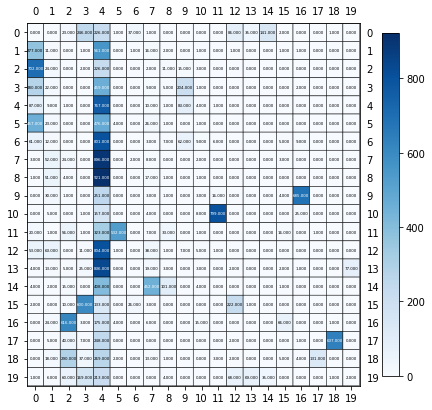

In [257]:
#(a) using best result in SVD which is r = 300 to visualize the clustering results 
r=300
best_lsa_data = TruncatedSVD(n_components=r, random_state=42).fit_transform(tfidf)

contingency_matrix, scores = get_kmeans_results (best_lsa_data, targets, 20)
print("contingency matrix when r =", r)
print(contingency_matrix)
plot_mat(contingency_matrix)

print("Homogeneity: %f" % scores['Homogeneity'])
print("Completeness: %f" % scores['Completeness'])
print("V-measure: %f" % scores['V-measure'])
print("Adjusted Rand Score: %f" % scores['Adjusted Rand Score'])
print("Adjusted Mutual Info Score: %f" % scores['Adjusted Mutual Info Score'])





contingency matrix when r = 10
[[  0  44   0   1   0  96 239   0   1   2   9  81 100   1  26 101  14   0
    0  84]
 [ 13 353   0   0   0   4   0   3   8 302   0 108   1   1   0 140  19   0
    1  20]
 [ 11 196   0   0   0   3   0  24   2 584   0  75   0   1   0  60  12   2
    0  15]
 [ 17 249   0   0   0   1   0 199   2 131   0 138   0   7   0 101  14  87
    4  32]
 [  9 357   0   0   0   1   0 128   4  57   0  91   0   5   0 255  17  15
    2  22]
 [ 18 349   0   0   0   0   0   1  15 351   0 131   0   1   0  73  14   0
   12  23]
 [ 11 246   3   0   0   4   1  88   1  34   0 128   0  20   0 380  18  12
    1  28]
 [ 17 139   0   0   0 103   0   2   4   4   0 336   0   8   0 283   6   0
    0  88]
 [ 21 149   0   0   0  41  15   2   2   4   0 368   0  28   0 168  12   0
    0 186]
 [  3  57 127   0   0   3   1   0   1   0   0 107   0 463   0 170  26   0
    0  36]
 [  3  25 407   0   0   1   1   0   0   0   0  22   0 473   0  48  10   0
    0   9]
 [ 17  65   0 238   0  35   0   0 

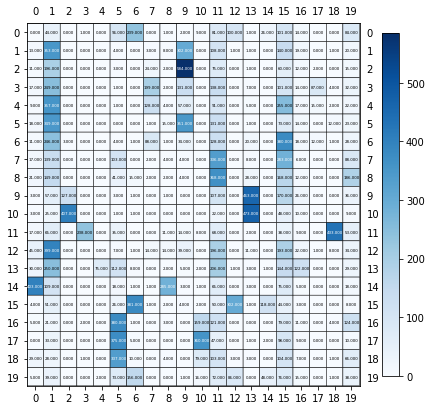

In [258]:
#(a) using best result in NMF which is r = 10 to visualize the clustering results 
r=10
best_nmf_data = NMF(n_components=r, random_state=42).fit_transform(tfidf)

contingency_matrix, scores = get_kmeans_results (best_nmf_data, targets, 20)
print("contingency matrix when r =", r)
print(contingency_matrix)
plot_mat(contingency_matrix)

print("Homogeneity: %f" % scores['Homogeneity'])
print("Completeness: %f" % scores['Completeness'])
print("V-measure: %f" % scores['V-measure'])
print("Adjusted Rand Score: %f" % scores['Adjusted Rand Score'])
print("Adjusted Mutual Info Score: %f" % scores['Adjusted Mutual Info Score'])




contingency matrix when r = 300
[[  0 195 122   0 387   0  41   0   0   0   0   0   0   5   0  42   5   0
    2   0]
 [  0 689   0   0 142   0   0   6   0   1   0   0   0  66   0  54   0  15
    0   0]
 [ 13 431   0   2 292   1   0   2   0   3   0   0   0 158   0  44   0   5
    0  34]
 [ 10 403   0   0 199   0   0   0   1   1   0   0   0 298   0  43   0  13
    0  14]
 [  2 507   0   0 253   1   0   1   0   5   0   0   0 107   0  23   0  49
    0  15]
 [  5 757   0   0 125   2   0   3   0   1   0   0   0  43   0  27   0  15
    0  10]
 [  2 725   0   0 143   0   0   0   1   9   1   0   0  90   0   0   1   2
    0   1]
 [  0 521   0   0 329  10   0   3   1   2  34   0   0  62   0  12   0  16
    0   0]
 [  4 649   0   0 245  13   0   0   0   3  16   0   0  58   0   6   0   2
    0   0]
 [  0 518   0   0 434   0   0   0   0   3   0   0   0  38   0   1   0   0
    0   0]
 [  0 542   0   0 396   0   0   0   0   8   0   0   0  26   0   0   1  26
    0   0]
 [  1 218   0   0 410   0   0   0

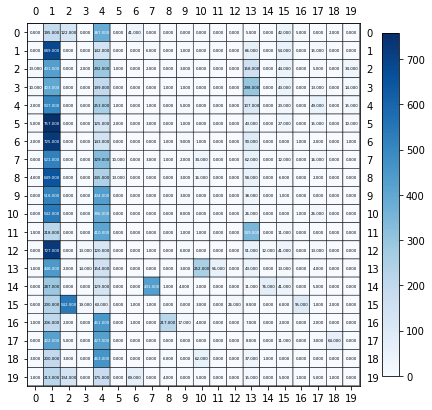

In [259]:
#(a) using best result in SVD which is r = 300 and normalized
r=300
best_lsa_data = TruncatedSVD(n_components=r, random_state=42).fit_transform(tfidf)

best_lsa_data = StandardScaler().fit_transform(best_lsa_data)

contingency_matrix, scores = get_kmeans_results (best_lsa_data, targets, 20)
print("contingency matrix when r =", r)
print(contingency_matrix)

plot_mat(contingency_matrix)

print("Homogeneity: %f" % scores['Homogeneity'])
print("Completeness: %f" % scores['Completeness'])
print("V-measure: %f" % scores['V-measure'])
print("Adjusted Rand Score: %f" % scores['Adjusted Rand Score'])
print("Adjusted Mutual Info Score: %f" % scores['Adjusted Mutual Info Score'])

contingency matrix when r = 10
[[  0  65   1 202  74  76   0   0   0   0  64   0   0   4   1  71   8  46
   90  97]
 [ 97   3  16   1  44  88   0   0   1   0  15   0   3 402   0 137   0   0
  163   3]
 [335   2   4   0  21  61   0   0   0   2   7   1  21 376   0  61   0   0
   94   0]
 [ 38   0   8   0  55 131   0   0   3  86  19   7 196 227   0 102   0   0
  110   0]
 [  5   1  10   0 102  97   0   0   1  15  13   3 126 173   0 151   0   0
  264   2]
 [127   0  27   0  24 111   0   0  12   0  14   0   1 462   0 108   0   0
  101   1]
 [  8   2   7   1 150 125   0   3   0  12  22  16  83  65   0 144   0   0
  334   3]
 [  0  85   8   0  99 269   0   0   0   0  65   6   2   9   0 158   0   0
  248  41]
 [  0  62  16   3  64 331   0   0   0   0 152  18   2  16   0 155   0   0
  169   8]
 [  0   4   3   0  72 105   0 116   0   0  31 428   0   2   0  63   0   0
  166   4]
 [  0   0   3   1  42  28   0 379   0   0   7 464   0   0   0  25   0   0
   49   1]
 [  8  18  20   0  17  57   0   0 

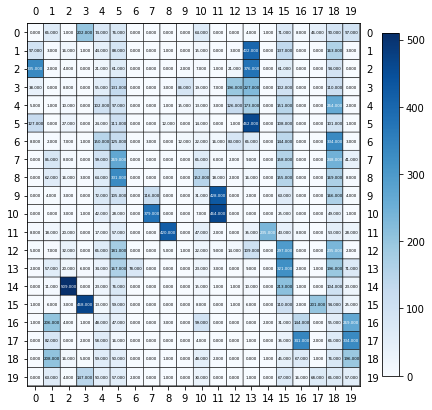

In [260]:
#(a) using best result in NMF which is r = 10 to visualize the clustering results 
r=10
best_nmf_data = NMF(n_components=r, random_state=42).fit_transform(tfidf)
best_nmf_data = StandardScaler().fit_transform(best_nmf_data)

contingency_matrix, scores = get_kmeans_results (best_nmf_data, targets, 20)
print("contingency matrix when r =", r)
print(contingency_matrix)
plot_mat(contingency_matrix)

print("Homogeneity: %f" % scores['Homogeneity'])
print("Completeness: %f" % scores['Completeness'])
print("V-measure: %f" % scores['V-measure'])
print("Adjusted Rand Score: %f" % scores['Adjusted Rand Score'])
print("Adjusted Mutual Info Score: %f" % scores['Adjusted Mutual Info Score'])

contingency matrix when r = 10
[[  1   0 235   1  44 122  62  12   0  22  24   1   5 246   3   4   0   1
   15   1]
 [  1 178   6  38   5   0  39  68  28  52   1  11 354   3  29  31 119   7
    0   3]
 [  0 232   6  58   1   0  17  21  48  20   3   3 404   0  16  14 133   5
    1   3]
 [  0  49   1 304   9   0  16  30 335  23   0   8  76   1  26  19  76   4
    0   5]
 [  2  26   0 183   6   0  24  25 364  80   0  13  60   0  64  14  90   4
    3   5]
 [  1 392   4  21   3   1  24  27   1  30   0  15 355   0   8  38  52  10
    1   5]
 [ 29  25   3 117  22   3  16  20 250 201   2   4  36   0  59  23 115   5
    6  39]
 [  4  52   1  28 200   1  22  63   7 106  67   5  16   4 308  30  13   8
   11  44]
 [  7  79   1  40 161   1  35  89  16  53 102   1   5  21 193  29   8   6
    5 144]
 [472   6   8   1   4   1  34  24   0  55   0   0   2   0  65   7  35   0
    2 278]
 [725   3   5   0   1   1   6   9   0  10   0   0   0   0   4   7  26   0
    1 201]
 [  0  16   2  10  13   0  19  43 

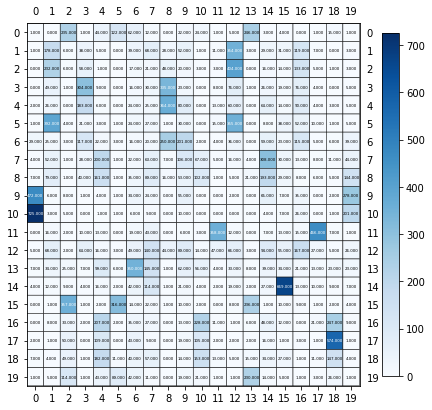

In [262]:
#(a) using best result in NMF which is r = 10 to visualize the clustering results 
r=10
best_nmf_data = NMF(n_components=r, random_state=42).fit_transform(tfidf)
#best_nmf_data = StandardScaler().fit_transform(best_nmf_data)

for x in np.nditer(best_nmf_data, op_flags=['readwrite']):
    if x == 0:
        x[...] = x + 0.001

best_nmf_data = np.log(best_nmf_data)

contingency_matrix, scores = get_kmeans_results (best_nmf_data, targets, 20)
print("contingency matrix when r =", r)
print(contingency_matrix)
plot_mat(contingency_matrix)

print("Homogeneity: %f" % scores['Homogeneity'])
print("Completeness: %f" % scores['Completeness'])
print("V-measure: %f" % scores['V-measure'])
print("Adjusted Rand Score: %f" % scores['Adjusted Rand Score'])
print("Adjusted Mutual Info Score: %f" % scores['Adjusted Mutual Info Score'])

contingency matrix when r = 10
[[  0  50  30   0  47   0  33   9 229   4  64   1   1  40   3 266   1  11
    1   9]
 [  1  29  19 197  28  22   3   0   2  27   3 169   5   4   7   0  28 340
   12  77]
 [  0  13  13 250  12  51   3   2   0  12   0 228   4   1   2   1  20 326
   14  33]
 [  3  14  29  67  23 400   2   0   1  13   1 209   5   4   4   0  15 116
   17  59]
 [  2  22  31  41  61 408   4   0   0  11  12 108   1   1  10   0  27 154
    6  64]
 [  4  20  20 208  12   0   0   0   1  26   0 311  10   0   1   0  28 300
   18  29]
 [ 12  20  96  15 220 243   4   0   1  12  16  69   4   7  47   2  16  96
   19  76]
 [  4  14 159   2  92  15  84   1   4  22  38  27   4 228  17   0  46  32
   36 165]
 [ 26  23 216   0  53  19 133   0  18   9   9  60   1 140  28   0  43  25
   48 145]
 [231  11  75   0  39   0  10   0   0   7   7   5   0  32 499   0  20  11
    8  39]
 [441   2  18   2  10   0   3   1   0   5   0   1   0   2 491   0   9   2
    2  10]
 [  1  23  15  11  10   5  14  19 

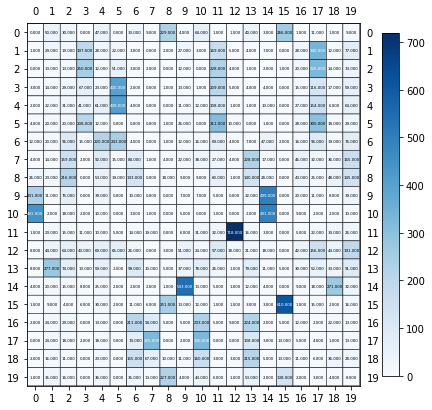

In [263]:
#(a) using best result in NMF which is r = 10 to visualize the clustering results 
r=10
best_nmf_data = NMF(n_components=r, random_state=42).fit_transform(tfidf)
best_nmf_data = StandardScaler(with_mean=False).fit_transform(best_nmf_data)

for x in np.nditer(best_nmf_data, op_flags=['readwrite']):
    if x == 0:
        x[...] = x + 0.1

best_nmf_data = np.log(best_nmf_data)

contingency_matrix, scores = get_kmeans_results (best_nmf_data, targets, 20)
print("contingency matrix when r =", r)
print(contingency_matrix)
plot_mat(contingency_matrix)

print("Homogeneity: %f" % scores['Homogeneity'])
print("Completeness: %f" % scores['Completeness'])
print("V-measure: %f" % scores['V-measure'])
print("Adjusted Rand Score: %f" % scores['Adjusted Rand Score'])
print("Adjusted Mutual Info Score: %f" % scores['Adjusted Mutual Info Score'])

contingency matrix when r = 10
[[ 14   4  21   0   2  31   0 253   0   1   1  76   0   2   4  15  29   1
  263  82]
 [128  11   1 180  15   0  24   1   0   9 151   7  58  13  26 270   6  23
    2  48]
 [ 85   3   7 252  20   0  60   0   0   5 192   1  22   8  10 243   7  51
    1  18]
 [ 60   3   0  39  16   2 286   1   0   9  51   4  82   7  11  64   9 334
    0   4]
 [ 56  15   0  20   7  10 382   0   0   3  29   5 138   7   9  95  10 172
    0   5]
 [121   2   0 199  21   2   3   1   0  19 340   5  12  11  30 179   6  17
    0  20]
 [ 52  66   0  11  19  16 304   0   2   4  41   1 129  35  13 133  40  97
    3   9]
 [  9  29  16   4  43  35  18   3   0   7  58  41 163  95  25  74 310  34
    1  25]
 [ 12  42  23   0  45  10  27  21   0   4  83  60  77 229  13  32 231  32
    0  55]
 [  6 422   0   0   6   6   0   0 184   0   5  33  24 209   9  20  28   0
    0  42]
 [  0 408   0   2   1   1   0   0 370   0   3   4   9 166  12   3   4   0
    0  16]
 [ 34   2   8   7  42  13   0   0 

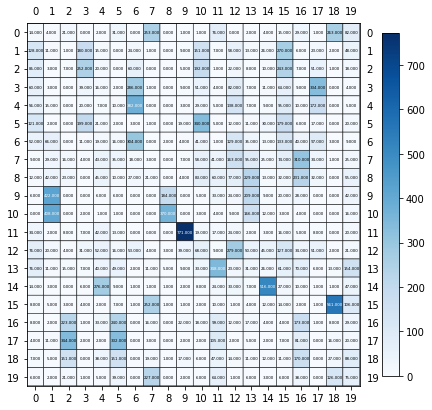

In [264]:
r=10
best_nmf_data = NMF(n_components=r, random_state=42).fit_transform(tfidf)

for x in np.nditer(best_nmf_data, op_flags=['readwrite']):
    if x == 0:
        x[...] = x + 0.001

best_nmf_data = np.log(best_nmf_data)

best_nmf_data = StandardScaler().fit_transform(best_nmf_data)

contingency_matrix, scores = get_kmeans_results (best_nmf_data, targets, 20)
print("contingency matrix when r =", r)
print(contingency_matrix)
plot_mat(contingency_matrix)

print("Homogeneity: %f" % scores['Homogeneity'])
print("Completeness: %f" % scores['Completeness'])
print("V-measure: %f" % scores['V-measure'])
print("Adjusted Rand Score: %f" % scores['Adjusted Rand Score'])
print("Adjusted Mutual Info Score: %f" % scores['Adjusted Mutual Info Score'])